## Downloading Data from Kaggle

In [ ]:
import pathlib
import os

# Identify the desired folder
kaggle_path = pathlib.Path.home() / "Documents" / "Python Projects" / "Guided"

# Set permissions so only my user can read it
os.chmod(kaggle_path / "kaggle.json", 0o600)

# Tell Kaggle API to use this folder
os.environ["KAGGLE_CONFIG_DIR"] = str(kaggle_path)

# Download datasets from Kaggle
!kaggle datasets download -d mssmartypants/rice-type-classification -p ./rice-type-classification --unzip

## Packages

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Manually detect GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Data Exploration

In [3]:
original_data = pd.read_csv("riceClassification.csv")

In [4]:
df = original_data.copy()
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
df.dropna(inplace=True) # Drop rows with missing value
df.drop(['id'], axis=1, inplace=True)
print(df.shape)

(18185, 11)


In [6]:
df.Class.value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

The frequency table shows a slight imbalanced proportion of labels within the dataset. There are more labels of _1 (Jasmine)_ (9985) than there are _0 (Gonen)_ (8200). To correct this imbalance the majority label will be downsampled to match the minorty label.

In [7]:
# Separate dataset by label
gonen = df.copy().query("Class == 0")
jasmine = df.copy().query("Class == 1")

# Downsample Jasmine samples to match Gonen samples
jasmine_downsampled = jasmine.sample(n=len(gonen))

# Create balanced dataset
df = pd.concat([gonen, jasmine_downsampled])

# Check if samples for each label are equal
df.Class.value_counts()

Class
0    8200
1    8200
Name: count, dtype: int64

## Creating Training, Test and Validation Datasets

In [8]:
# Feature variables
X = np.array(df.iloc[: , :-1])

# Target variable
y = np.array(df.iloc[: , -1])

In [9]:
# Split dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Split dataset into testing and validation data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print(
    X_train.shape,
    X_test.shape,
    X_val.shape,
    sep='\n'
)

(11480, 10)
(2460, 10)
(2460, 10)


## Preprocessing: Standardisation

Each variable has a different scale, with some substantially larger than others. At its current state, the difference in scale would introduce bias in the neural network resulting in a less accurate model. To mitigate this problem, the dataset will undergo normalisation where each value is divided by the largest absolute value in its respective column.

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## Transforming into Tensor Data

In [12]:
class dataset(Dataset):
    # Transform data into tensor datatype and move the tensor data to the device (i.e., CPU, GPU)
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    # Returns the shape of the feature tensor data
    def __len__(self):
        return len(self.X)

    # Retrieve specific item from an index
    def __getitem__(self, item):
        return self.X[item], self.y[item]

## PyTorch Implementation

In [13]:
hidden_neurones = 10

class Model(nn.Module):

    def __init__(self):
        # Use the same constructor inherited from nn.Module
        super(Model, self).__init__()

        # Multi-layer perceptron
        self.input_layer = nn.Linear(X.shape[1], hidden_neurones)   # Input is 10 features and the output is a number of hidden neurones
        self.linear = nn.Linear(hidden_neurones, 1)     # Hidden layer input of hidden neurones with one output layer producing a probability (0 if < 0.5 or 1 if > 0.5)
        self.sigmoid = nn.Sigmoid()     # Sigmoid activation function

    # Forward propagation : How the data passes through the model
    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [14]:
model = Model().to(device)

summary(model, (X.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


The above summary shows the neural network's architecture and parameters:

```
Input (10 features) → Linear Layer (10 neurons) → Linear Layer (1 neuron) → Sigmoid → Output (probability)
```

**Layer 1 - Linear-1 (Input Layer):**
- Input: 10 features (i.e., dataset features)
- Output: 10 hidden neurones
- Parameters: 110 (10 inputs × 10 outputs + 10 biases = 110)

**Layer 2 - Linear-2 (Output Layer):**
- Input: 10 hidden neurones
- Output: 1 neuron (i.e., binary classification)
- Parameters: 11 (10 inputs × 1 output + 1 bias = 11)

**Layer 3 - Sigmoid-3 (Activation):**
- Applies sigmoid function to convert output to probability (0-1)
- Parameters: 0 (i.e., activation functions do not have trainable parameters)

### Training

`DataLoader` applies a batch of data to the neural network at every epoch.

In [15]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
test_data = dataset(X_test, y_test)

train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [16]:
# Binary cross-enthrophy loss
criterion = nn.BCELoss()

# Optimising model parameters
optimiser = Adam(model.parameters(), lr=1e-3)

In [17]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    # Training each batch (size=8) of data
    for data in train_dataloader:
        inputs, labels = data

        # Generate prediction
        prediction = model(inputs).squeeze(1)

        # Calculate loss for each batch of data
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()

        # Returns a list of boolean comparing predicted and actual values (True, False)
        acc = (prediction.round() == labels).sum().item()
        total_acc_train += acc

        # Backwards propagation
        batch_loss.backward()
        optimiser.step()
        optimiser.zero_grad()   # Restart optimiser


    # Use the model for validations purposes (i.e., no change to weights)
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()
            acc = (prediction.round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))    # Percentage score
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))

    print(
        f"Epoch no.: {epoch+1}",
        f"Training loss: {round(total_loss_train/1000, 4)}",
        f"Training accuracy: {round(total_acc_train/training_data.__len__() * 100, 4)}",
        f"Validation loss: {round(total_loss_val/1000, 4)}",
        f"Validation accuracy: {round(total_acc_val/validation_data.__len__() * 100, 4)}",
        "-----",
        sep='\n'
    )


Epoch no.: 1
Training loss: 0.113
Training accuracy: 98.1185
Validation loss: 0.011
Validation accuracy: 98.6179
-----
Epoch no.: 2
Training loss: 0.0608
Training accuracy: 98.5714
Validation loss: 0.0093
Validation accuracy: 98.9024
-----
Epoch no.: 3
Training loss: 0.0594
Training accuracy: 98.6672
Validation loss: 0.0093
Validation accuracy: 98.9024
-----
Epoch no.: 4
Training loss: 0.0582
Training accuracy: 98.6672
Validation loss: 0.0084
Validation accuracy: 98.9837
-----
Epoch no.: 5
Training loss: 0.0578
Training accuracy: 98.7631
Validation loss: 0.0086
Validation accuracy: 98.9431
-----
Epoch no.: 6
Training loss: 0.0573
Training accuracy: 98.7544
Validation loss: 0.0083
Validation accuracy: 99.1057
-----
Epoch no.: 7
Training loss: 0.0567
Training accuracy: 98.7369
Validation loss: 0.008
Validation accuracy: 99.065
-----
Epoch no.: 8
Training loss: 0.056
Training accuracy: 98.7805
Validation loss: 0.0078
Validation accuracy: 99.0244
-----
Epoch no.: 9
Training loss: 0.0559
Tr

## Visualisation

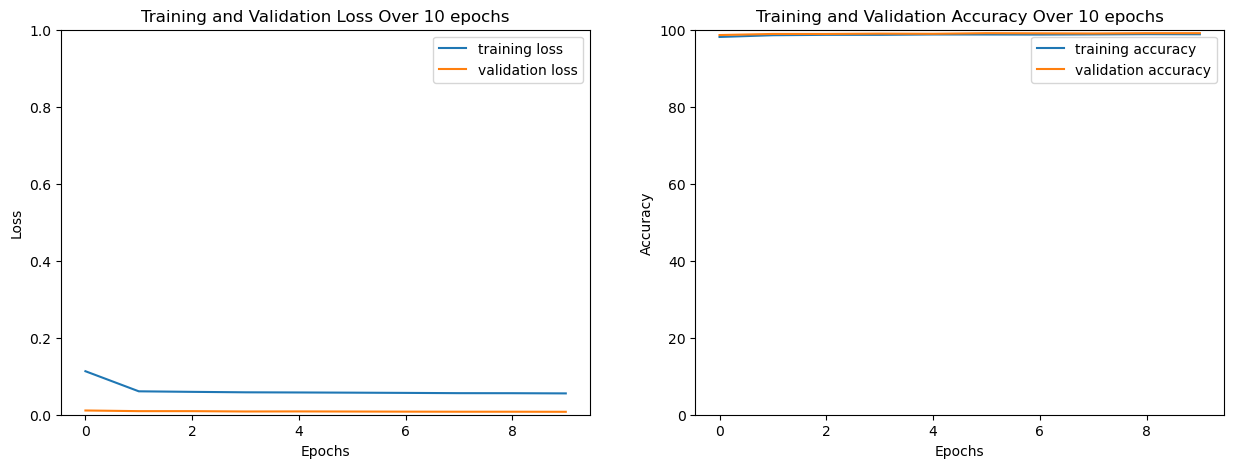

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(total_loss_train_plot, label = "training loss")
axes[0].plot(total_loss_validation_plot, label = "validation loss")
axes[0].set(
    title=f"Training and Validation Loss Over {epochs} epochs",
    xlabel='Epochs',
    ylabel='Loss',
    ylim=([0, 1])
)
axes[0].legend()


axes[1].plot(total_acc_train_plot, label = "training accuracy")
axes[1].plot(total_acc_validation_plot, label = "validation accuracy")
axes[1].set(
    title=f"Training and Validation Accuracy Over {epochs} epochs",
    xlabel='Epochs',
    ylabel='Accuracy',
    ylim=([0, 100])
)
axes[1].legend()

### Testing Model

In [19]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for data in test_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test

        acc = (prediction.round() == labels).sum().item()
        total_acc_test += acc

print(f"Test accuracy: {round(total_acc_test / test_data.__len__() * 100, 4)}")

Test accuracy: 98.4146


## Making Predictions

In [20]:
from random import uniform

In [138]:
samples = []

for i in range(10):
    sample_dict = {}

    for var in original_data.columns[1:-1]:

        # Randomly generate a datapoint within the column - Sample between max and min value in the variable
        s = uniform(original_data[var].min(), original_data[var].max()).item()

        sample_dict[var] = s

    # Convert sample values into a list
    sample_values = list(sample_dict.values())

    # Reshape for standardisation (1, n_features)
    sample_array = np.array(sample_values).reshape(1, -1)

    # Standardisation
    sample_standardised = scaler.transform(sample_array)

    # Transform to tensor data
    sample_tensor = torch.tensor(sample_standardised, dtype=torch.float32).to(device)

    # Use the sampled datapoint as input into the model
    sample_pred = model(sample_tensor)

    # Append the prediction to the list
    samples.append(round(sample_pred.item()))

In [139]:
samples

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1]